In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_tuner import RandomSearch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import os
import time
import warnings

warnings.filterwarnings("ignore")

C:\Users\willy\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# LSTM
## Modelo de Predicción de Series de Tiempo de Delitos Informáticos

## Preprocesamiento de los datos
Carga de los datos, definición de carpetas para guardar resultados (tablas e imágenes) y creación del dataframe.

In [2]:
# Crear carpeta para guardar las tablas en la ruta especificada
output_dir = 'C:/Users/willy/anaconda3/TFM/LSTM_output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Leer y preprocesar los datos
file_path = 'C:/Users/willy/anaconda3/TFM/DI_2019_2024.xlsx'
xls = pd.ExcelFile(file_path)
data = pd.read_excel(xls, sheet_name='Hoja1')

# Crear un DataFrame con los campos necesarios
df = data[['departamento_hecho', 'fecha_hecho', 'delito_agrupado']]
df['fecha_hecho'] = pd.to_datetime(df['fecha_hecho'])

# Filtrar los registros hasta el 5 de mayo de 2024
fecha_limite = '2024-05-05'
df = df[df['fecha_hecho'] <= fecha_limite]

# Añadir una nueva columna 'categoria_delito' basada en las condiciones especificadas
df['categoria_delito'] = df['delito_agrupado'].apply(lambda x: 1 if x in ['Hurto por medios informáticos', 'Transferencia no consentida'] else 0)
df.set_index('fecha_hecho', inplace=True)

## Definición de funciones

In [3]:
# Función para construir el modelo con búsqueda aleatoria de hiperparámetros
def build_model_lstm(hp, seq_length, input_shape):
    model = tf.keras.Sequential()
    
    # Añadir una o dos capas LSTM
    for i in range(hp.Int('num_lstm_layers', 1, 2)):  
        model.add(tf.keras.layers.LSTM(units=hp.Choice('units_lstm_' + str(i), [32, 64, 128]),
                                       return_sequences=True if i == 0 else False,
                                       input_shape=input_shape))
        model.add(tf.keras.layers.Dropout(rate=hp.Choice('dropout_rate_' + str(i), [0.2, 0.4, 0.6])))
    
    # Capa de salida
    model.add(tf.keras.layers.Dense(1))
    
    # Selección de optimizador y tasa de aprendizaje
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate', [0.1, 0.01]))
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(hp.Choice('learning_rate', [0.1, 0.01]))
    else:
        optimizer = tf.keras.optimizers.SGD(hp.Choice('learning_rate', [0.1, 0.01]))
    
    # Compilar el modelo
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

## Función principal para procesar las series de tiempo de todos los departamentos por categoría de delito

In [4]:
# Función para procesar cada categoría de delito
def process_category(df, categoria_delito, title, filename_prefix):
    df_filtered = df[df['categoria_delito'] == categoria_delito]
    
    # Contar el número de registros por departamento y ordenarlos
    departamento_counts = df_filtered['departamento_hecho'].value_counts()
    departamentos = departamento_counts.index

    # Crear subplots para la evolución de la pérdida
    fig_loss, axes_loss = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), constrained_layout=True)
    fig_loss.suptitle(f"Evolución de la pérdida - {title}", fontsize=18)

    # Crear subplots para las predicciones
    fig_pred, axes_pred = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), constrained_layout=True)
    fig_pred.suptitle(f"Predicciones - {title}", fontsize=18)

    # Lista para guardar métricas
    resultados_metricas = []

    print(f"Procesando: Categoria de Delito: {categoria_delito}")
    
    for i, departamento in enumerate(departamentos):
        print(f"Procesando departamento: {departamento}...")
        
        df_depto = df_filtered[df_filtered['departamento_hecho'] == departamento]

        # Resamplear los datos a frecuencia semanal
        df_week = df_depto.resample('W-SUN').size().reset_index(name='Casos')
        df_week.set_index('fecha_hecho', inplace=True)

        #print(f"Longitud de df_week: {len(df_week)}")
        
        # Aplicar transformación logarítmica a la serie de tiempo
        df_week['Casos_log'] = np.log(df_week['Casos'] + 1)

        # Dividir los datos en entrenamiento y prueba
        train = df_week[df_week.index.year < 2024]
        test = df_week[df_week.index.year == 2024].head(18)
        
        #print(f"Longitud de Prueba: {len(test)}")
        
        # Escalar los datos
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_train = scaler.fit_transform(train[['Casos_log']])
        scaled_test = scaler.transform(test[['Casos_log']])

        # Convertir la serie temporal en una secuencia de datos para el LSTM
        seq_length = 4
        def create_sequences(data, seq_length):
            X, y = [], []
            for i in range(len(data) - seq_length):
                X.append(data[i:i + seq_length])
                y.append(data[i + seq_length])
            return np.array(X), np.array(y)

        X_train_full, y_train_full = create_sequences(scaled_train, seq_length)
        X_test, y_test = create_sequences(scaled_test, seq_length)

        # Dividir en entrenamiento y validación
        X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

        #print(f"Longitud de Entrenamiento: {len(X_train)}")
        #print(f"Longitud de Validación: {len(X_val)}")
            
        # Redimensionar los datos para LSTM
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        input_shape = (seq_length, X_train.shape[2])

        # Crear el sintonizador de hiperparámetros
        tuner_lstm = RandomSearch(
            lambda hp: build_model_lstm(hp, seq_length, input_shape),
            objective='val_loss',
            max_trials= 50,  # Número de combinaciones de hiperparámetros a probar
            executions_per_trial=1,  # Número de ejecuciones para cada prueba
            directory='hyperparam_search',
            project_name=f'lstm_tuning_{departamento}'
        )

        # Realizar la búsqueda aleatoria de hiperparámetros
        epochs = 50
        start_time = time.time()
        tuner_lstm.search(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0) # Verbose = 0 para reducir la salida
        end_time = time.time()
        training_time = end_time - start_time

        # Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
        best_model_lstm = tuner_lstm.get_best_models(num_models=1)[0]

        # Entrenar el mejor modelo y capturar el historial
        history = best_model_lstm.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

        # Predicción y evaluación
        predictions = best_model_lstm.predict(X_test)

        #print(f"Longitud de predictions: {len(predictions)}")

        # Aplicar la transformación inversa logarítmica a las predicciones y datos de prueba
        predictions = scaler.inverse_transform(predictions)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Transformar de nuevo a la escala real
        predictions = np.exp(predictions) - 1
        y_test_real = np.exp(y_test) - 1  # Asegurar que se transforma correctamente

        # Transformar todo el conjunto de prueba completo a la escala real
        test_real = np.exp(np.log(test['Casos'] + 1)) - 1  # Transformar el conjunto de prueba a escala real
        
        #print(f"Longitud de y_test_real: {len(y_test_real)}")
        #print(f"Longitud de predictions: {len(predictions)}")
        
        # Calcular métricas de error
        rmse = np.sqrt(mean_squared_error(y_test_real, predictions))
        mae = mean_absolute_error(y_test_real, predictions)
        rmsle_value = np.sqrt(np.mean((np.log1p(y_test_real) - np.log1p(predictions)) ** 2))

        # Calcular la Hellinger Distance
        p = y_test_real / np.sum(y_test_real)
        q = predictions / np.sum(predictions)
        hd = np.sqrt(1 - np.sum(np.sqrt(p * q)))

        mean_df = df_week['Casos'].mean()
        
        # Guardar las métricas
        resultados_metricas.append([departamento, mean_df, rmse, mae, rmsle_value, hd, training_time])

        # Graficar la evolución de la pérdida
        row = i // 2
        col = i % 2
        axes_loss[row, col].plot(history.history['loss'], label='Pérdida de Entrenamiento', lw=1.5)
        axes_loss[row, col].plot(history.history['val_loss'], label='Pérdida de Validación', lw=1.5)
        axes_loss[row, col].set_title(departamento, fontsize=14)
        axes_loss[row, col].set_xlabel('Épocas', fontsize=12)
        axes_loss[row, col].set_ylabel('Pérdida', fontsize=12)
        axes_loss[row, col].legend()

        # Graficar predicciones vs valores reales con el formato ajustado
        train_real = np.exp(scaler.inverse_transform(scaled_train)) - 1
        val_real = np.exp(scaler.inverse_transform(scaled_train[-len(X_val):])) - 1

        # Datos de entrenamiento (escala real)
        axes_pred[row, col].plot(train.index, train_real, label='Entrenamiento', lw=1.5, color='tab:blue')

        # Datos de validación (escala real)
        axes_pred[row, col].plot(train.index[-len(X_val):], val_real, label='Validación', lw=1.5, color='tab:cyan')

        # Datos de prueba (escala real)
        axes_pred[row, col].plot(test.index, test_real, label='Prueba', lw=1.5, color='tab:orange')

        # Predicciones
        axes_pred[row, col].plot(test.index[-len(predictions):], predictions, label='Predicción', lw=1.5, color='tab:green')

        # Establecer título y etiquetas
        axes_pred[row, col].set_title(departamento, fontsize=14)
        axes_pred[row, col].set_xlabel('Años', fontsize=12)
        axes_pred[row, col].set_ylabel('Cantidad de Casos', fontsize=12)
        # Añadir la leyenda
        axes_pred[row, col].legend(loc='upper left', fontsize=10)

    # Guardar las gráficas
    fig_loss.savefig(f'{output_dir}/{filename_prefix}_perdida.png')
    fig_pred.savefig(f'{output_dir}/{filename_prefix}_predicciones.png')
    plt.show()

    # Crear DataFrame para los resultados de métricas y guardarlos en un archivo Excel
    resultados_metricas_df = pd.DataFrame(resultados_metricas, columns=['Departamento', 'Media', 'RMSE', 'MAE', 'RMSLE', 'Distancia Hellinger', 'Tiempo de entrenamiento'])
    resultados_metricas_df.to_excel(f'{output_dir}/{filename_prefix}_metricas.xlsx', index=False)

## Procesamiento de datos 'categoria_delito' = 0, 
## 'Atentados contra la confidencialidad, la integridad y la disponibilidad de los datos y de SI'

Procesando: Categoria de Delito: 0
Procesando departamento: Bogotá DC...
Procesando departamento: Antioquia...
Procesando departamento: Cundinamarca...
Procesando departamento: Valle del Cauca...
Procesando departamento: Atlántico...
Procesando departamento: Santander...
Procesando departamento: Tolima...
Procesando departamento: Norte de Santander...
Procesando departamento: Bolívar...
Procesando departamento: Risaralda...


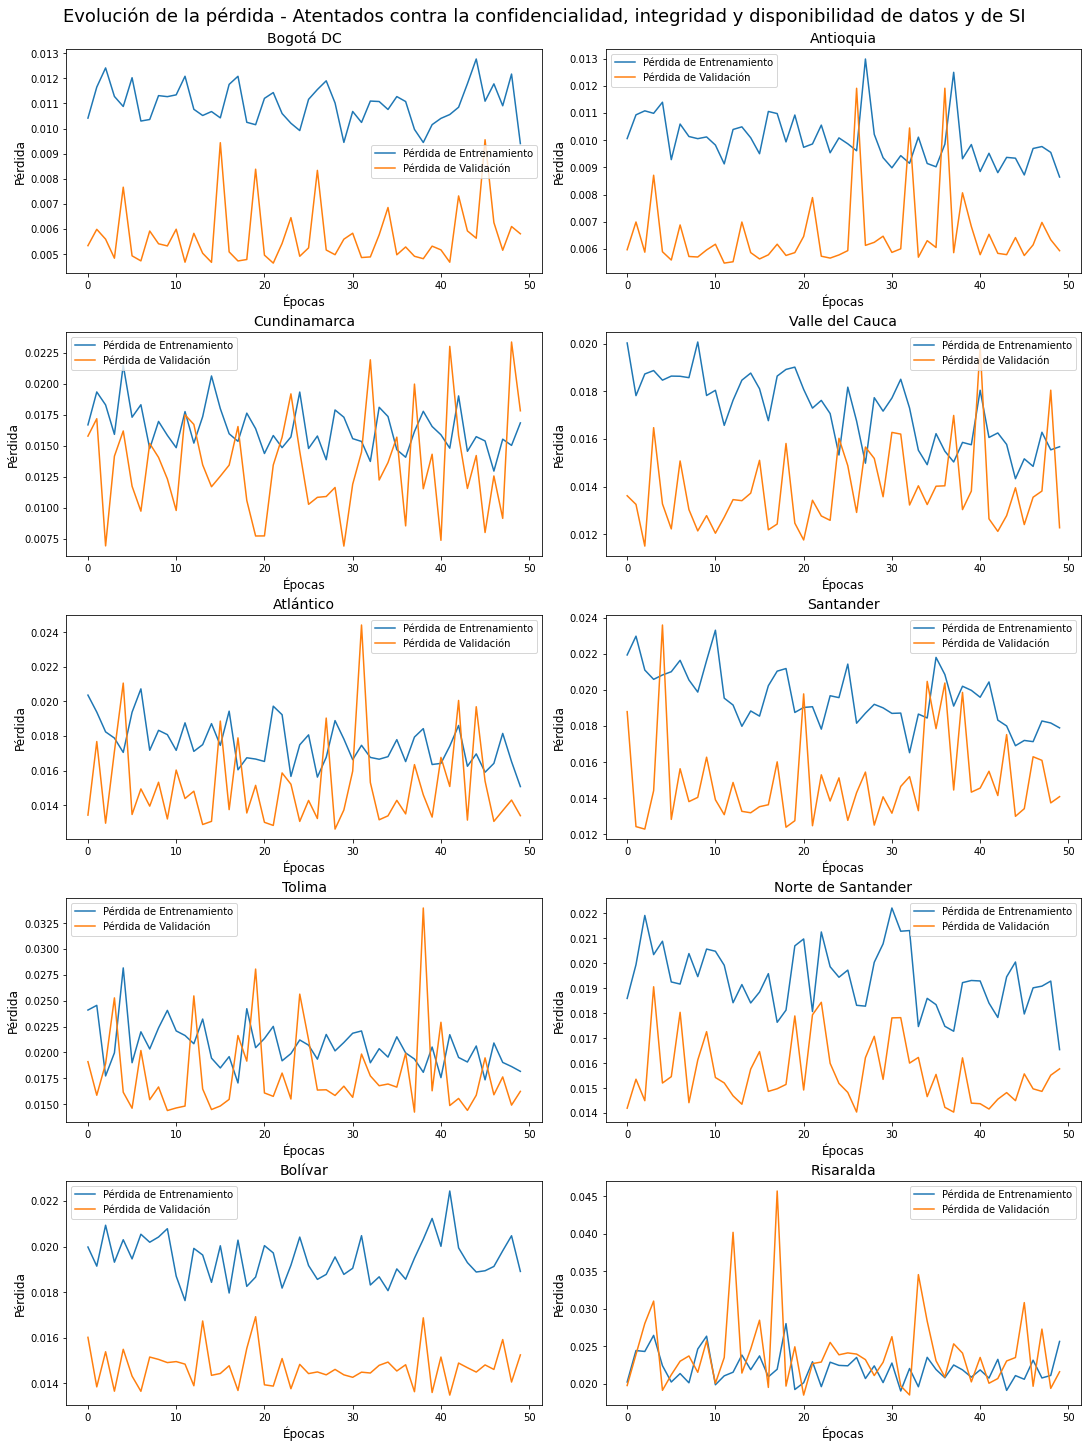

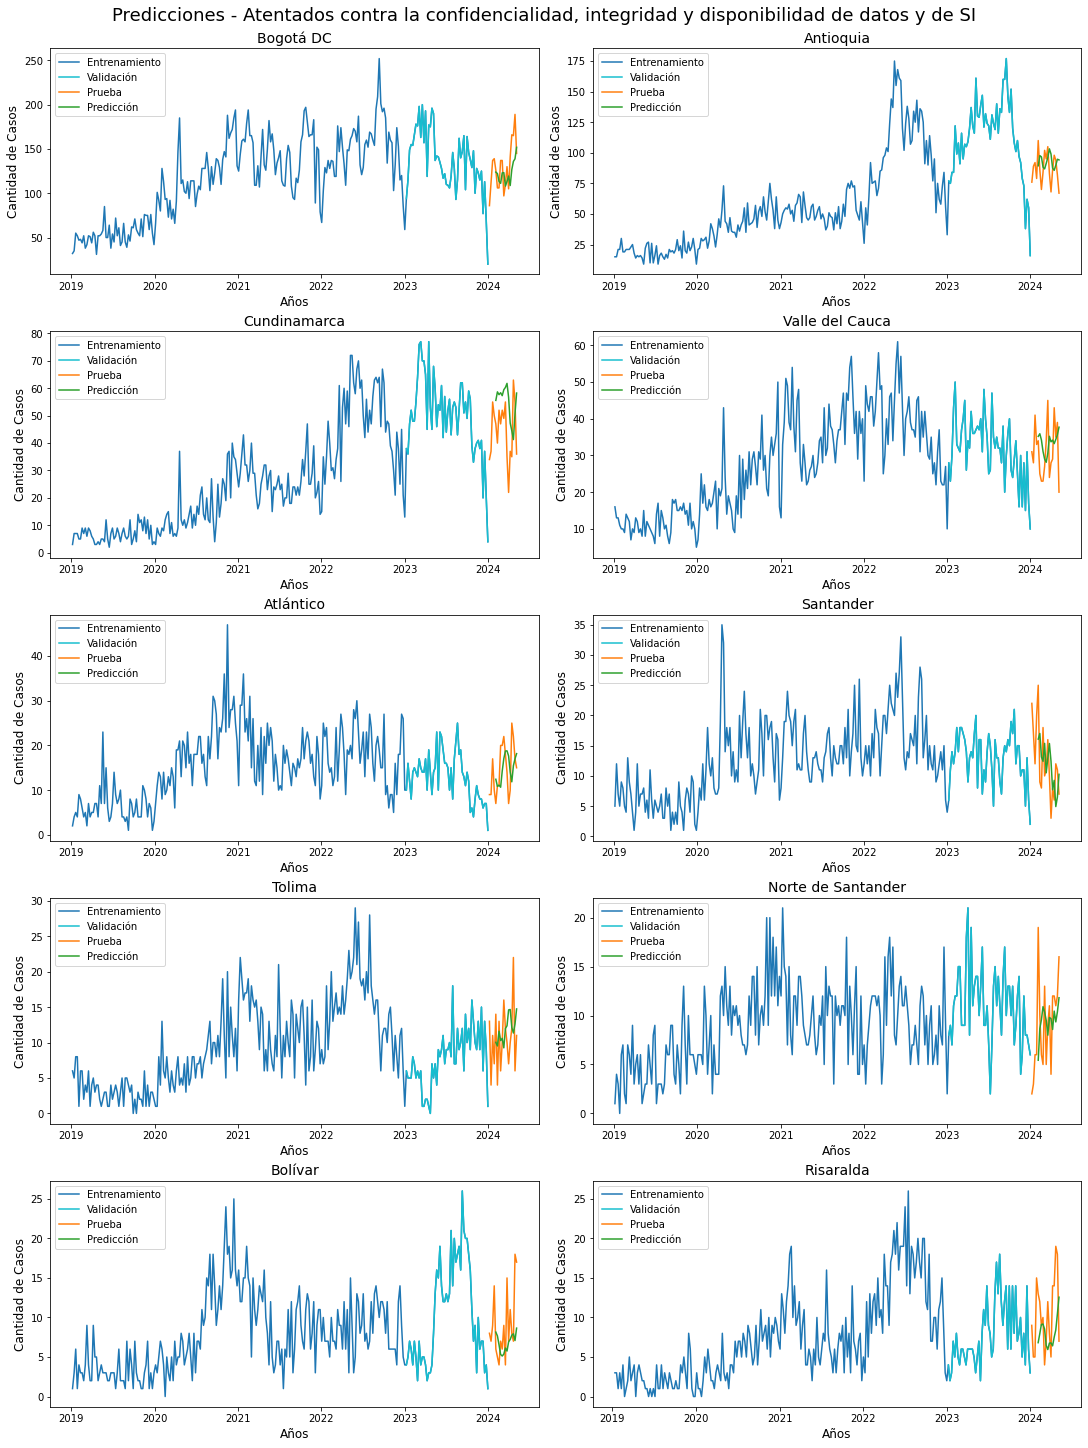

In [8]:
# Procesar datos de 'categoria_delito' = 0
process_category(df, 0, 'Atentados contra la confidencialidad, integridad y disponibilidad de datos y de SI', 'categoria_0_LSTM')

## Procesamiento de datos 'categoria_delito' = 1,
## 'Atentados informáticos y otras infracciones'

Procesando: Categoria de Delito: 1
Procesando departamento: Bogotá DC...
Reloading Tuner from hyperparam_search\lstm_tuning_Bogotá DC\tuner0.json
Procesando departamento: Antioquia...
Reloading Tuner from hyperparam_search\lstm_tuning_Antioquia\tuner0.json
Procesando departamento: Valle del Cauca...
Reloading Tuner from hyperparam_search\lstm_tuning_Valle del Cauca\tuner0.json
Procesando departamento: Cundinamarca...
Reloading Tuner from hyperparam_search\lstm_tuning_Cundinamarca\tuner0.json
Procesando departamento: Santander...
Reloading Tuner from hyperparam_search\lstm_tuning_Santander\tuner0.json
Procesando departamento: Atlántico...
Reloading Tuner from hyperparam_search\lstm_tuning_Atlántico\tuner0.json
Procesando departamento: Tolima...
Reloading Tuner from hyperparam_search\lstm_tuning_Tolima\tuner0.json
Procesando departamento: Bolívar...
Reloading Tuner from hyperparam_search\lstm_tuning_Bolívar\tuner0.json
Procesando departamento: Risaralda...
Reloading Tuner from hyperparam

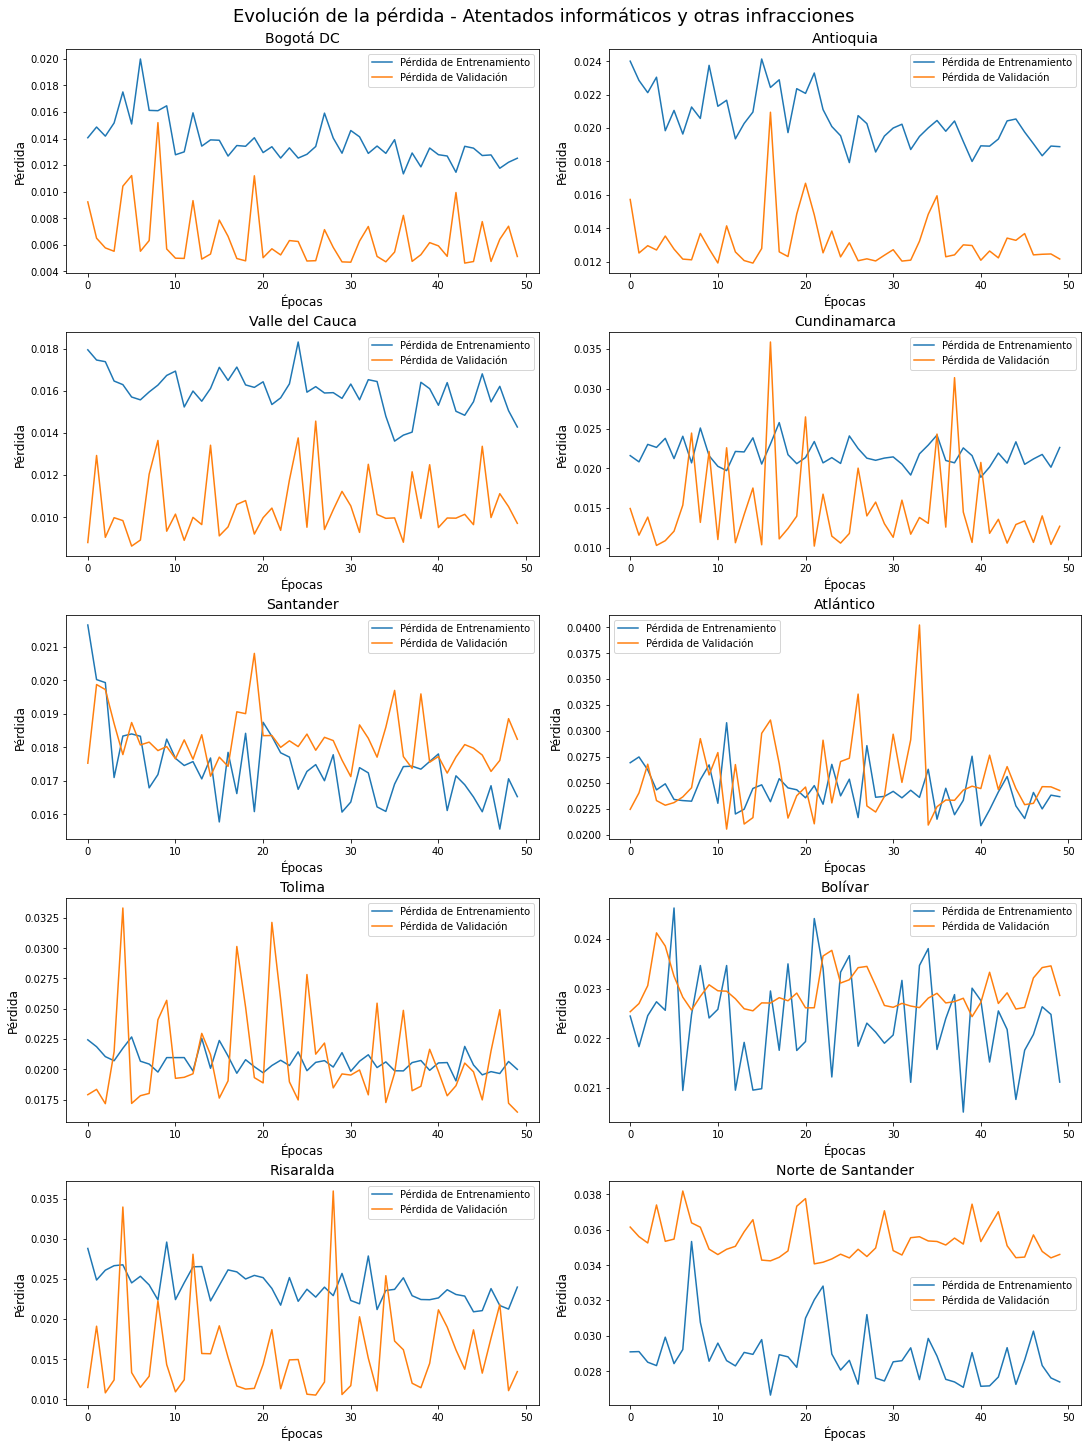

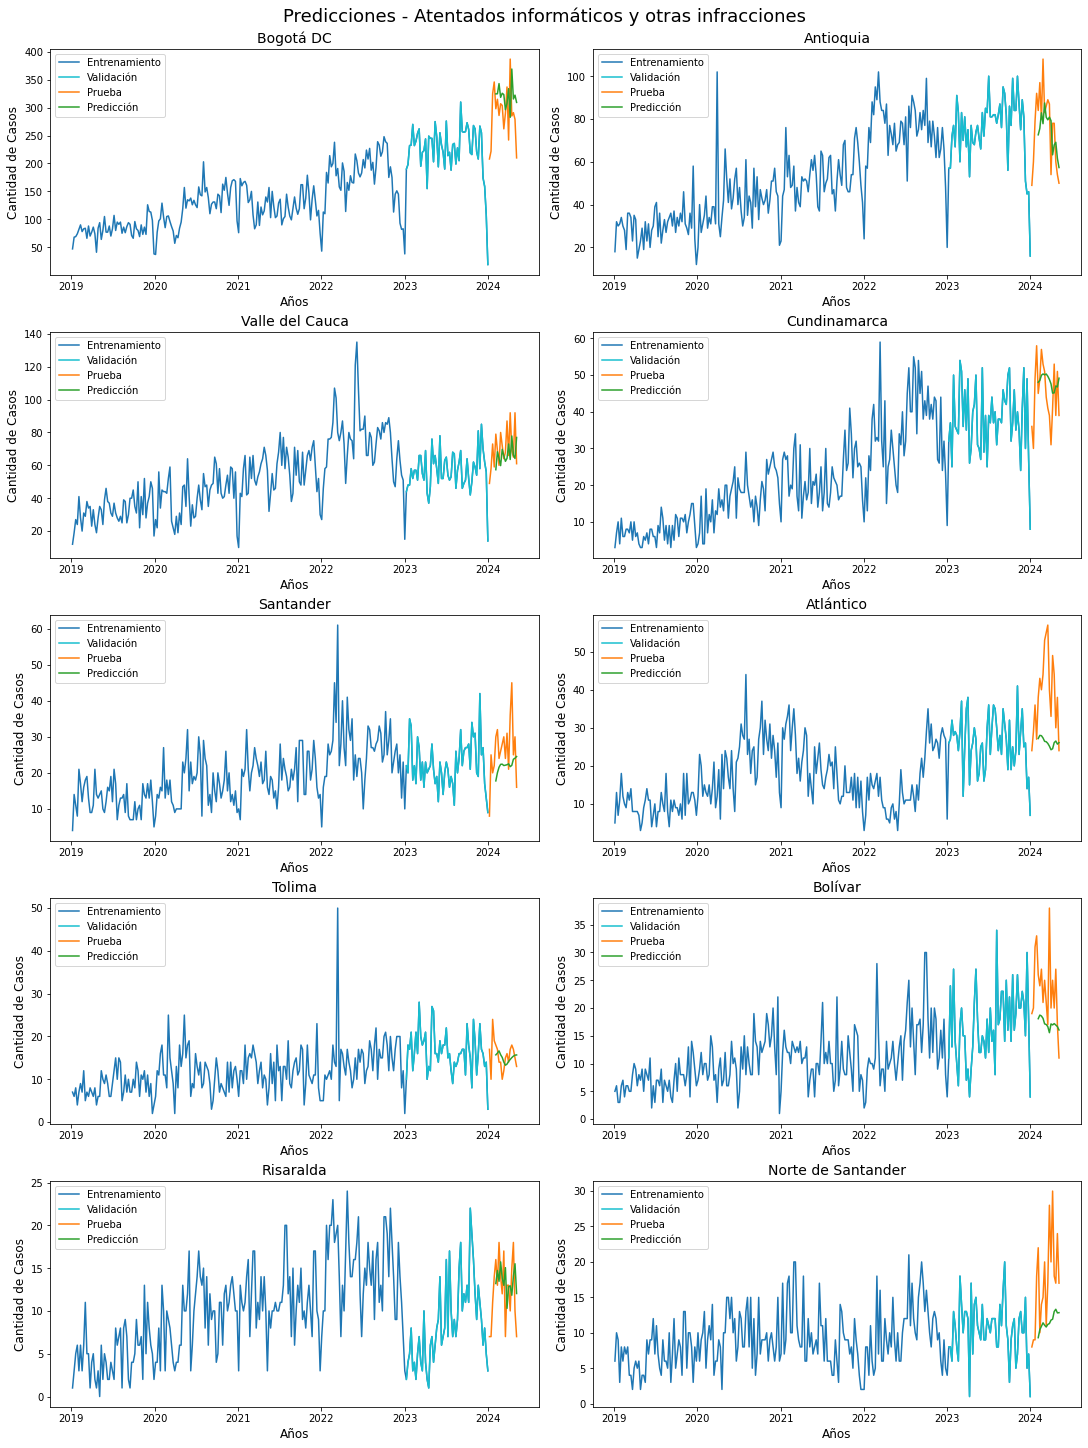

In [5]:
# Procesar datos de 'categoria_delito' = 1
process_category(df, 1, 'Atentados informáticos y otras infracciones', 'categoria_1_LSTM')